# Modelo General del RIT - David

In [1]:
import pandas as pd
import numpy as np
import utils as ut # esta librería tiene funciones para poder obtener un procesamiento del <T,H>
import spacy

/home/david/anaconda3/envs/rit/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# from sentence_transformers import SentenceTransformer, util, InputExample, losses
# #Load the model(here we use minilm)
# model = SentenceTransformer('all-MiniLM-L6-v2')

## Empezaremos con cargar los words embeddings de GLOVE
### Se pueden cambiar por los que sean necesarios

In [4]:
nlp = spacy.load("en_core_web_md") # modelo de nlp

In [5]:
ut.load_vectors_in_lang(nlp,"data/glove.840B.300d.txt") # carga de vectores en nlp.wv

## Lectura de los pares <T,H> para realizar las pruebas
### se cargará la información de los textos e hipótesis en listas

In [7]:
prueba=pd.read_csv("data/RTE3/DEV_1.csv")  # archivo donde se tiene almacenado la información de los pares <T,H>
prueba

,sentence1,sentence2,gold_label
0,The sale was made to pay Yukos' US$ 27.5 billi...,Baikalfinansgroup was sold to Rosneft.,YES
1,The sale was made to pay Yukos' US$ 27.5 billi...,Yuganskneftegaz cost US$ 27.5 billion.,NO
2,Loraine besides participating in Broadway's Dr...,"""Does A Tiger Have A Necktie"" was produced in ...",UNKNOWN
3,"""The Extra Girl"" (1923) is a story of a small-...","""The Extra Girl"" was produced by Sennett.",YES
4,A bus collision with a truck in Uganda has res...,30 die in a bus collision in Uganda.,YES
...,...,...,...
95,Live At Leeds (1970) is The Who's first live a...,Live At Leeds was recorded by The Who.,YES
96,"In June 2004, top Russian oil producer Lukoil ...",Lukoil earned $1 billion in 2004.,UNKNOWN
97,"Scott's execution led to outrage in Ontario, a...",Louis Riel assassinated Scott.,UNKNOWN
98,The Extra Girl (1923) is a story of a small-to...,Mabel Normand starred in The Extra Girl.,YES


In [8]:
textos = prueba["sentence1"].to_list()       # almacenamiento en listas
hipotesis = prueba["sentence2"].to_list()
print(textos)
print(hipotesis)

["The sale was made to pay Yukos' US$ 27.5 billion tax bill, Yuganskneftegaz was originally sold for US$ 9.4 billion to a little known company Baikalfinansgroup which was later bought by the Russian state-owned oil company Rosneft .", "The sale was made to pay Yukos' US$ 27.5 billion tax bill, Yuganskneftegaz was originally sold for US$9.4 billion to a little known company Baikalfinansgroup which was later bought by the Russian state-owned oil company Rosneft .", 'Loraine besides participating in Broadway\'s Dreamgirls, also participated in the Off-Broadway production of "Does A Tiger Have A Necktie". In 1999, Loraine went to London, United Kingdom. There she participated in the production of "RENT" where she was cast as "Mimi" the understudy.', '"The Extra Girl" (1923) is a story of a small-town girl, Sue Graham (played by Mabel Normand) who comes to Hollywood to be in the pictures. This Mabel Normand vehicle, produced by Mack Sennett, followed earlier films about the film industry an

## Procesamiento de todos los pares:
### Limpieza de los textos (eliminación de puntuación)
### Obtener su representación de embeddings normalizada
### Obtener su representación de embeddings no normalizada (esto para el calculo de la distancia euclideana)
### Generar matriz de producto puntos de vectores

In [9]:
import mutual_info as mi

from scipy.stats import wasserstein_distance

import conceptnet_lite
conceptnet_lite.connect("data/conceptnet.db")
from conceptnet_lite import Label, edges_for

In [10]:
## esta función revisa hiperonimia, sinonimia entre otras.
def encontrar_relaciones(relaciones):
    borrar=set()
    borrar_i=set()
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]    
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "synonym"==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else:
                        if e.start.text==wt:
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                elif "is_a" ==e.relation.name:
                    if wh== e.end.text:
                        if e.start.text==wt:
                            print(wt," is_a ",wh)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    else: ##quitar y la busqueda de relacioens
                        if wh== e.end.text:
                            if e.start.text==wt:
                                print(wt," is_a ",wh)
                                borrar.add(c)
                                borrar_i.add(index)
                                break
                elif "has_a"==e.relation.name:
                    if wt== e.end.text:
                        if e.start.text==wh:
                            print(wh," has_a ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                    
                elif "derived_from" == e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," derivado_from ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                elif "used_for" == e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," used_for ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
                elif "HasProperty" == e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," HasProperty ",wt)
                            borrar.add(c)
                            borrar_i.add(index)
                            break
        except:
            a=0
    return list(borrar),list(borrar_i)

In [11]:
def encontrar_relaciones_contrarias(relaciones):
    antonyms=[]
    borrar=[]
    borrar_i=[]
    for r in relaciones:
        index=r[0]
        c=r[1]
        wt=str(index).split("{")[1].split(",")[0]
        wh=str(c).split("{")[1].split(",")[0]
        try:
            for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                if "antonym" ==e.relation.name:
                    if wt== e.start.text:
                        if e.end.text==wh:
                            print(wt," antonym ",wh)
                            # borrar.append(c)
                            # borrar_i.append(index)
                            antonyms.append(wt)
                            break
                        else:
                            print(wh," antonym ",wt)
                            # borrar.append(c)
                            # borrar_i.append(index)
                            antonyms.append(wt)
                            break
                elif "distinct_from" ==e.relation.name:
                    if wh== e.start.text:
                        if e.end.text==wt:
                            print(wh," distinct from ",wt)
                            # borrar.append(c)
                            # borrar_i.append(index)
                            antonyms.append(wt)
                            break
                    else:
                        if e.start.text==wt:
                            print(wt," distinct from ",wh)
                            # borrar.append(c)
                            # borrar_i.append(index)
                            antonyms.append(wt)
                            break
        except:
            a=0
    return borrar,borrar_i,antonyms

In [12]:
def encontrar_relaciones_cercanas(indexes,columnas):
    borrar=[]
    borrar_i=[]
    related=[]
    for index in indexes:
        for c in columnas:
            wt=str(index).split("{")[1].split(",")[0]
            wh=str(c).split("{")[1].split(",")[0]
            try:
                for e in edges_for(Label.get(text=wh, language='en').concepts, same_language=True):
                    # if "related_to" ==e.relation.name:
                    #     if wt== e.start.text:
                    #         if e.end.text==wh:
                    #             print(wt," related_to ",wh)
                    #             borrar.append(c)
                    #             borrar_i.append(index)
                    #             related.append(wt)
                    #             break
                    #         else:
                    #             print(wh," related_to ",wt)
                    #             borrar.append(c)
                    #             borrar_i.append(index)
                    #             related.append(wt)
                    #             break
                    if "similar_to" ==e.relation.name:
                        if wh== e.start.text:
                            if e.end.text==wt:
                                print(wh," similar_to ",wt)
                                borrar.append(c)
                                borrar_i.append(index)
                                related.append(wt)
                                break
                        else:
                            if e.start.text==wt:
                                print(wt," similar_to ",wh)
                                borrar.append(c)
                                borrar_i.append(index)
                                related.append(wt)
                                break
                    elif "is_a" ==e.relation.name:
                        if wh== e.start.text:  ######
                            if e.end.text==wt:
                                print(wh," is_a ",wt)
                                borrar.add(c)
                                borrar_i.add(index)
                                break
                    elif "has_a"==e.relation.name:
                        if wh== e.end.text:
                            if e.start.text==wt:
                                print(wh," has_a ",wt)
                                borrar.add(c)
                                borrar_i.add(index)
                                break
            except:
                a=0
    return borrar,borrar_i,related

In [13]:
def obtener_distancia(texto_v,hipotesis_v,texto_t,texto_h,b_col,b_index):
    lista_l=[]
    for i in range(len(texto_t)):
        lista=[]
        for j in range(len(texto_h)):
            lista.append(np.linalg.norm(texto_v[i] - hipotesis_v[j]))#*wasserstein_distance(texto_2[i],hipotesis_2[j]))
        lista_l.append(lista)
    df_distEuc=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    col=df_distEuc.columns
    borrar=[]
    # for c in col:
    #     if "{null" in str(c) or "{be,VERB" in str(c) or ("NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
    #         borrar.append(c)        
    # borrar_i=[]
    # indexes=df_distEuc.index
    # for index in indexes:
    #     if "{null" in str(index) or "{be,VERB" in str(index) or ("NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
    #         borrar_i.append(index)    
    df_distEuc=df_distEuc.drop(b_col[1:],axis=1)
    df_distEuc=df_distEuc.drop(b_index[1:],axis=0)
    #print(df_distEuc)
    return df_distEuc.min().sum()

In [14]:
def wasserstein_mutual_inf(texto_v,hipotesis_v,texto_t,texto_h):  
    lista_l=[]
    lista_muinfor=[]   
    for i in range(len(texto_t)):
        lista=[]
        lista_mu=[]
        for j in range(len(texto_h)):
            lista.append(wasserstein_distance(texto_v[i],hipotesis_v[j]))
            lista_mu.append(mi.mutual_information_2d(np.array(texto_v[i]),np.array(hipotesis_v[j])))
        lista_l.append(lista)
        lista_muinfor.append(lista_mu)
    DFmearth=pd.DataFrame(lista_l,index=texto_t,columns=texto_h)
    DFmutual_inf=pd.DataFrame(lista_muinfor,index=texto_t,columns=texto_h)
    return DFmearth,DFmutual_inf

In [15]:
def entropia(X):
    """Devuelve el valor de entropia de una muestra de datos""" 
    probs = [np.mean(X == valor) for valor in set(X)]
    return round(sum(-p * np.log2(p) for p in probs), 3)

In [16]:
import time

# Proceso principal

In [18]:
sumas=[]
distancias=[]
entropias=[]
etiquetas=[]
mearts=[]
mutinf=[]
max_info=[]
list_antonimos=[]
listas_malign=[]
lista_anto=[]
lista_related=[]
lista_relatedT=[]
lista_restante=[]
similaridad_faltantes=[]
inicio = time.time()

for i in range(len(textos)):
#for i in range(44,45):
    print(i)
    t_vectors=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    h_vectors=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=False,lemmatize=False)
    t_vectors_n=ut.get_matrix_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_vectors_n=ut.get_matrix_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    t_clean=ut.get_words_rep(textos[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)
    h_clean=ut.get_words_rep(hipotesis[i],nlp,pos_to_remove=['PUNCT'], normed=True,lemmatize=False)

    # INTRASENTENCE
    # intra_text=np.dot(t_vectors_n,t_vectors_n.T)
    # intra_hipotesis=np.dot(h_vectors_n,h_vectors_n.T)
    # ma_text=pd.DataFrame(intra_text,index=t_clean,columns=t_clean)
    # ma_text=pd.DataFrame(np.triu(ma_text.values,k=1),index=t_clean,columns=t_clean)
    # ma_hipo=pd.DataFrame(intra_hipotesis,index=h_clean,columns=h_clean)
    # ma_hipo=pd.DataFrame(np.triu(ma_hipo.values,k=1),index=h_clean,columns=h_clean)
    # print(ma_text.T.idxmax())
    # print(ma_hipo.T.idxmax())
    
    # Obtencion de matriz de alineamiento, matriz de move earth y mutual information
    ma=np.dot(t_vectors_n,h_vectors_n.T)
    #print(len(t_vectors_n),len(h_vectors_n),len(t_clean),len(h_clean))
    m_earth,m_mi=wasserstein_mutual_inf(t_vectors_n,h_vectors_n,t_clean,h_clean)
    ma=pd.DataFrame(ma,index=t_clean,columns=h_clean)
    print(ma)
    ###### BORRADO DE COSAS QUE NO OCUPO, SOLO NOS QUEDAMOS CON INFORMACIÓN DE TIPOS DE PALABRA: NOUN, VERB, ADJ Y ADV
    # TAMBIÉN OMITIMOS EL VERBO BE DEBIDO A QUE POR LO REGULAR SE UTILIZA COMO AUXILIAR Y ES UN VERBO COPULATIVO
    # sirve para construir la llamada predicación nominal del sujeto de una oración: 
    # #el sujeto se une con este verbo a un complemento obligatorio llamado atributo que por lo general determina 
    # alguna propiedad, estado o equivalencia del mismo, por ejemplo: "Este plato es bueno". "Juan está casado". 

    b_col=[0]
    b_index=[0]
    print(ma)
    col=ma.columns
    borrar=[]
    indexes=ma.index
    for c in col:
        if "{null," in str(c) or "{be,VERB" in str(c) or ("not" not in str(c) and "PRON" not in str(c) and "NOUN" not in str(c) and "VERB" not in str(c) and "ADJ" not in str(c) and "ADV" not in str(c)):
            borrar.append(c)        
        elif str(c) in indexes:
            borrar.append(c)        
    borrar_i=[]
    for index in indexes:
        if "{null," in str(index) or "{be,VERB" in str(index) or ("not" not in str(index) and "PRON" not in str(index) and "NOUN" not in str(index) and "VERB" not in str(index) and "ADJ" not in str(index) and "ADV" not in str(index)):
            borrar_i.append(index) 
        elif str(index) in col:
            borrar_i.append(index) 
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    #print(ma)
    # ELIMINAMOS INFORMACIÓN DONDE SE CORRESPONDAN EN LEMMAS, TENGA UN PRODUCTO IGUAL A 1 Y SEAN IGUALES LOS INDICES Y COLUMNAS
    # SI EL VALOR ES IGUAL A 1 SIGNIFICA QUE ES LA MISMA PALABRA, O SON SINONIMOS
    borrar=[]
    borrar_i=[]
    col=ma.columns
    for index,strings in ma.iterrows():
        lema_i=str(index).split("{")[1].split(",")[0]
        for c in col:
            if index==c:
                borrar_i.append(index)
                borrar.append(c)
            if strings[c]>=1:
                borrar_i.append(index)
                borrar.append(c)
            lema_c=str(c).split("{")[1].split(",")[0]
            if lema_i == lema_c:
                borrar_i.append(index)
                borrar.append(c)
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    #print(ma)
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    #primera vuelta ---------------------------------------------------------------------------------
    # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET

    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    print("Proceso de hiponimias, sinonimia")
    borrar,borrar_i=encontrar_relaciones(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    b_col.extend(borrar)
    b_index.extend(borrar_i)
    #print(ma)
    # relaciones contrarias
    #PARA REVISAR SI EXISTEN RELACIONES CONTRARIAS A TRAVÉS DEL USO DE CONCEPNET
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    print("Proceso de antonimia o distinto de ")
    borrar,borrar_i,d=encontrar_relaciones_contrarias(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    #print(ma)
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    
    # segunda vuelta--------------------------------------------------------------------------------------------
    # #PARA REVISAR SI EXISTEN RELACIONES DE SIMILITUD SEMÁNTICA A TRAVÉS DEL USO DE CONCEPNET
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    print("Proceso de hiponimias, sinonimia")
    borrar,borrar_i=encontrar_relaciones(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)
    
    #print(ma)
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    
    #relaciones contrarias quitar
    a=ma.idxmax().values
    b=ma.columns
    rel=[]
    for i in range(len(a)):
        rel.append((a[i],b[i]))
    print("Proceso de antonimia o distinto de ")
    borrar,borrar_i,d1=encontrar_relaciones_contrarias(rel[:])
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    #print(ma)
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    
    # ultima VUELTA PARA CHECAR RELACIONES CERCANAS --------------------------------------------------
    # relaciones cercanas quitar
    indexes=ma.index
    columnas=ma.columns
    print("Proceso de relaciones")
    borrar,borrar_i,r_l2=encontrar_relaciones_cercanas(indexes,columnas)
    ma=ma.drop(borrar,axis=1)
    ma=ma.drop(borrar_i,axis=0)
    m_earth=m_earth.drop(borrar,axis=1)
    m_earth=m_earth.drop(borrar_i,axis=0)
    m_mi=m_mi.drop(borrar,axis=1)
    m_mi=m_mi.drop(borrar_i,axis=0)

    #print(ma)
    b_col.extend(borrar)
    b_index.extend(borrar_i)
    #   ALMACENAMIENTO DE TODA LA INFORMACIÓN PROCESADA
    #alamacenado de resultados
    sumas.append(ma.min().sum())
    if len(ma.columns)==0:
        max_info.append(0)
    else:
        max_info.append((ma.max().sum()/(ma.shape[1])))
    entropias.append(entropia(ma.round(2).values.flatten()))
    mearts.append(m_earth.max().sum())
    mutinf.append(m_mi.max().sum())

    distancias.append(obtener_distancia(t_vectors,h_vectors,t_clean,h_clean,b_col,b_index)) 
    print(ma)
    d2=[]   
    if d==[] and d1==[]:
        d2=[]
    else:
        d2=list(set(d+d1))
    r2=[]   
    if r_l2==[]:
        r2=[]
    else:
        r2=list(set(r_l2))
    list_antonimos.append(len(d2))
    listas_malign.append(ma)
    lista_anto.append(d2)
    lista_related.append(len(r2))
    lista_relatedT.append(r2)
    #print(ma)
    st=""
    sh=""
    for t__1 in ma.index:
        st=st+" "+str(t__1).split("{")[0]
    for t__2 in ma.columns:
        sh=sh+" "+str(t__2).split("{")[0]
    doc1 = nlp(st)
    doc2 = nlp(sh)
    #print(doc1, "<->", doc2, doc1.similarity(doc2))
    #print(st,sh)
    if st!="" and sh!="":
        similaridad_faltantes.append(doc1.similarity(doc2))
    elif st!="" and sh=="":
        similaridad_faltantes.append(1)
    else:
        similaridad_faltantes.append(0)
fin = time.time()
print("Tiempo que se llevo:",round(fin-inicio,2)," segundos")

0
                                           baikalfinansgroup{baikalfinansgroup,PROPN}  \
the{the,DET}                                                                      0.0   
sale{sale,NOUN}                                                                   0.0   
was{be,AUX}                                                                       0.0   
made{make,VERB}                                                                   0.0   
to{to,PART}                                                                       0.0   
pay{pay,VERB}                                                                     0.0   
yukos{yukos,PROPN}                                                                0.0   
us${us$,SYM}                                                                      0.0   
27{27,NUM}                                                                        0.0   
5{5,NUM}                                                                          0.0   
billion{billion,NUM

/tmp/ipykernel_274809/3587441395.py:237: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similaridad_faltantes.append(doc1.similarity(doc2))


                              alfredo{alfredo,PROPN}  \
cauhtemoc{cauhtemoc,PROPN}                  0.000000   
cardenas{cardenas,PROPN}                    0.000000   
said{say,VERB}                              0.040252   
during{during,ADP}                         -0.018673   
a{a,DET}                                    0.046399   
news{news,NOUN}                            -0.007912   
conference{conference,NOUN}                 0.009619   
on{on,ADP}                                 -0.088365   
7{7,NUM}                                   -0.050904   
june{june,PROPN}                            0.007956   
that{that,SCONJ}                           -0.050385   
the{the,DET}                                0.021398   
visit{visit,NOUN}                          -0.025374   
to{to,ADP}                                 -0.064867   
mexico{mexico,PROPN}                        0.276801   
by{by,ADP}                                  0.147975   
salvadoran{salvadoran,PROPN}                0.00

/tmp/ipykernel_274809/3587441395.py:237: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similaridad_faltantes.append(doc1.similarity(doc2))


                             general{general,ADJ}  dynamics{dynamic,NOUN}  \
general{general,ADJ}                     1.000000                0.386094   
dynamics{dynamic,NOUN}                   0.386094                1.000000   
the{the,DET}                             0.563538                0.450342   
maker{maker,NOUN}                        0.204016                0.232879   
of{of,ADP}                               0.464858                0.322885   
land{land,NOUN}                          0.355911                0.185369   
combat{combat,NOUN}                      0.332016                0.278372   
systems{system,NOUN}                     0.476242                0.543692   
warships{warship,NOUN}                   0.227479                0.122704   
and{and,CCONJ}                           0.555003                0.476262   
gulfstream{gulfstream,NOUN}              0.235821                0.373010   
business{business,NOUN}                  0.457571                0.368182   

In [19]:
distancias[0]

0.0

In [20]:
len(lista_relatedT)

100

In [21]:
clases=prueba["gold_label"].values
temp1 =np.array([sumas,distancias,entropias,mutinf,mearts,max_info,list_antonimos,lista_related,similaridad_faltantes,clases])
df_resultados = pd.DataFrame(temp1.T,columns=["suma","distancias","entropias","mutual_info","m_earth","max_info_p","antonimos","relaciones","sim_falt","CLASS"])
df_resultados

,suma,distancias,entropias,mutual_info,m_earth,max_info_p,antonimos,relaciones,sim_falt,CLASS
0,0.0,0.0,0,0.0,0.0,0,0,0,1,YES
1,-0.000762,74.020615,2.342,1.764418,0.09268,0.233517,0,0,0.48201,NO
2,-0.270946,89.141647,4.374,3.756787,0.093405,0.652533,0,0,0.620797,UNKNOWN
3,0.0,0.0,0,0.0,0.0,0,0,0,1,YES
4,-0.140882,69.899918,2.75,1.965056,0.012824,0.231184,0,0,0.088769,YES
...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0,0.0,0.0,0,0,0,1,YES
96,-0.014862,49.700527,3.664,1.884254,0.046068,0.364936,0,0,0.241961,UNKNOWN
97,0.0,34.537472,3.507,1.923065,0.0462,0.509925,0,0,0.651589,UNKNOWN
98,-0.121208,51.027462,4.056,1.930516,0.00986,0.541305,0,0,0.323551,YES


In [22]:
df_resultados.to_csv("salida/resultadoRTE_notebook.csv",index=False)

<Axes: title={'center': 'distancias'}, xlabel='CLASS'>

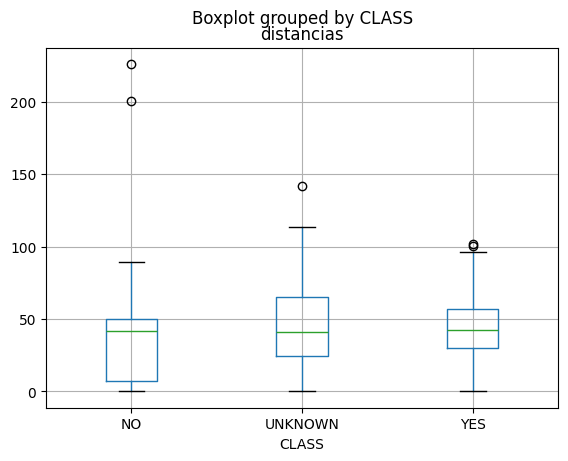

In [23]:
df_resultados.boxplot(by="CLASS",column=["distancias"])

array([<Axes: title={'center': 'entropias'}, xlabel='CLASS'>,
       <Axes: title={'center': 'mutual_info'}, xlabel='CLASS'>],
      dtype=object)

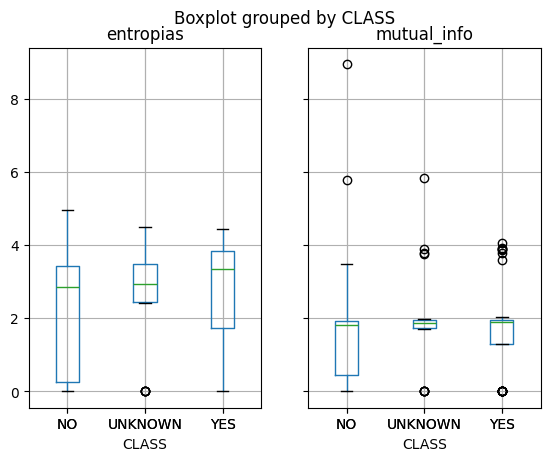

In [24]:
df_resultados.boxplot(by="CLASS",column=["entropias","mutual_info"])

array([<Axes: title={'center': 'm_earth'}, xlabel='CLASS'>,
       <Axes: title={'center': 'max_info_p'}, xlabel='CLASS'>],
      dtype=object)

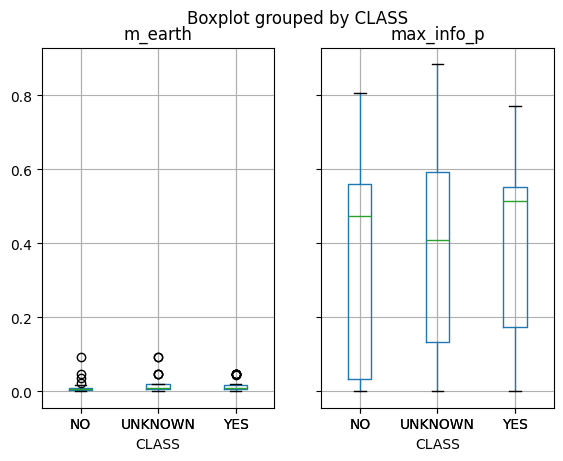

In [25]:
df_resultados.boxplot(by="CLASS",column=["m_earth","max_info_p"])

<Axes: title={'center': 'suma'}, xlabel='CLASS'>

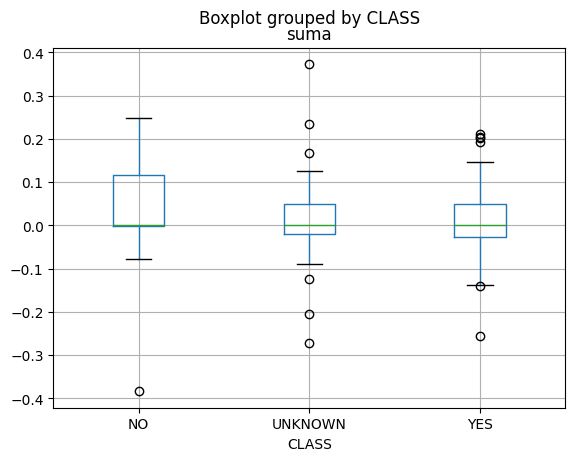

In [26]:
df_resultados.boxplot(by="CLASS",column=["suma"])

array([<Axes: title={'center': 'antonimos'}, xlabel='CLASS'>,
       <Axes: title={'center': 'relaciones'}, xlabel='CLASS'>],
      dtype=object)

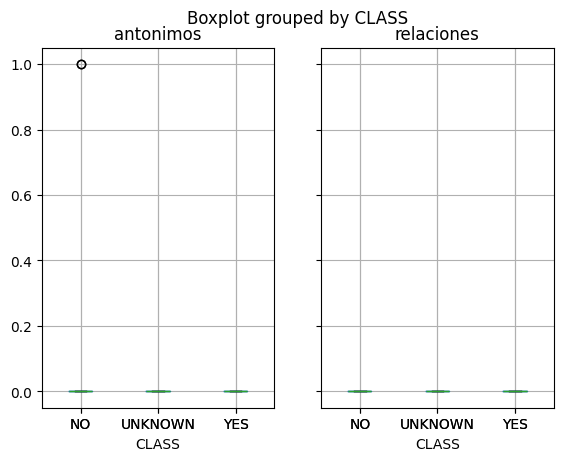

In [27]:
df_resultados.boxplot(by="CLASS",column=["antonimos","relaciones"])